第0次迭代，成本值为：0.6543912405149825


D:\DeepLearning\Lesson 2 Week 1\reg_utils.py:121: RuntimeWarning: divide by zero encountered in log
  logprobs = np.multiply(-np.log(a3),Y) + np.multiply(-np.log(1 - a3), 1 - Y)
D:\DeepLearning\Lesson 2 Week 1\reg_utils.py:121: RuntimeWarning: invalid value encountered in multiply
  logprobs = np.multiply(-np.log(a3),Y) + np.multiply(-np.log(1 - a3), 1 - Y)


第10000次迭代，成本值为：0.0610169865749056
第20000次迭代，成本值为：0.060582435798513114


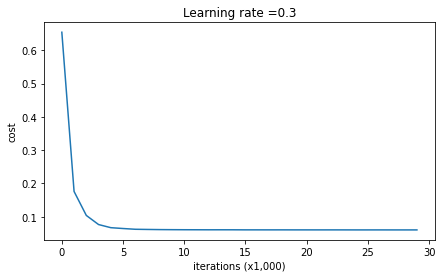

训练集:
Accuracy: 0.9289099526066351
测试集:
Accuracy: 0.95


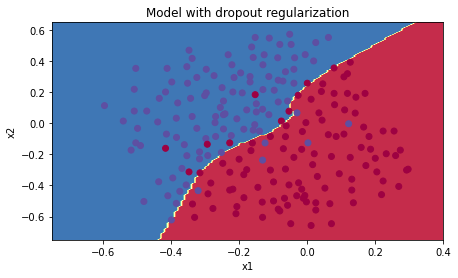

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import sklearn.datasets
import init_utils   
import reg_utils    
import gc_utils     
import testCases

%matplotlib inline 
plt.rcParams['figure.figsize'] = (7.0, 4.0) 
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'


train_X, train_Y, test_X, test_Y = reg_utils.load_2D_dataset(is_plot = False)

#1.不使用正则化

#2.使用正则化
#2.1 L2正则化
#2.2 droupout正则化
def model(X, Y, learning_rate = 0.3, num_iterations = 30000, print_cost = False, is_plot = False, lamda = 0, keep_prob = 1):
    """
    参数：
    X:输入数据
    Y:输入数据标签
    learning_rate:学习率
    num_iteration:迭代次数
    print_cost:是否打印成本
    is_plot:是否绘制梯度下降曲线图
    lamda:L2正则化中的参数 λ
    keep_prob:随机删除节点的概率
    
    返回值：
    parameters：神经网络参数
    
    """
    grads = {}
    costs = []
    m = X.shape[1]
    
    layer_dims = [X.shape[0], 20, 3, 1]
    #随便设计一个三层网络
    
    parameters = reg_utils.initialize_parameters(layer_dims)
    
    for i in range(0, num_iterations):
        #前向传播
        if keep_prob == 1:
            a3, cache = reg_utils.forward_propagation(X, parameters)
        elif keep_prob < 1 and keep_prob > 0:
            #根据keep_prob删除节点
            a3, cache = forward_propagation_dropout(X, parameters, keep_prob)
        else:
            print("keep_prob参数错误！")
            exit
            
        #计算成本
        #是否使用二范数
        if lamda == 0:
            #不使用L2正则化
            cost = reg_utils.compute_cost(a3,Y)
        else:
            #使用L2正则化
            cost = compute_cost_with_regularization(a3,Y,parameters,lamda)

        #反向传播
        
        #同时使用L2正则化和dropout正则化的情况不考虑
        assert(lamda == 0 or keep_prob == 1)
        
        if (lamda == 0 and keep_prob == 1):
            #不进行正则化的情况
            grads = reg_utils.backward_propagation(X, Y, cache)
        elif lamda != 0:
            #进行L2正则化
            grads = backward_propagation_with_regularization(X, Y, cache, lamda)
        elif keep_prob < 1:
            #进行dropout正则化
            grads = backward_propagation_with_dropout(X, Y, cache, keep_prob)
            
        #更新参数
        parameters = reg_utils.update_parameters(parameters, grads, learning_rate)
        
        #记录并打印成本
        if i % 1000 == 0:
            ## 记录成本
            costs.append(cost)
            if (print_cost and i % 10000 == 0):
                #打印成本
                print("第" + str(i) + "次迭代，成本值为：" + str(cost))
        
    #是否绘制成本曲线图
    if is_plot:
        plt.plot(costs)
        plt.ylabel('cost')
        plt.xlabel('iterations (x1,000)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()
    
    return parameters

def compute_cost_with_regularization(a3, Y, parameters, lamda):
    """
    功能：
    实现L2正则化的成本计算
    参数：
    a3:神经网络正向传播的输出，维度(n[3],m)
    Y:神经网络输出的标签，维度(n[3],m)
    parameters：神经网络参数
    lamda:L2正则化中的参数 λ
    返回值：
    cost:成本
    """
    
    #得到m和W[i]
    m = Y.shape[1]
    
    W1 = parameters["W1"]
    W2 = parameters["W2"]
    W3 = parameters["W3"]
    
    normal_cost = reg_utils.compute_cost(a3, Y)
    L2_regularization_cost = (lamda / (2 * m)) * (np.sum(np.square(W1)) + np.sum(np.square(W2)) + np.sum(np.square(W3)))
    
    cost = normal_cost + L2_regularization_cost
    
    return cost

def backward_propagation_with_regularization(X, Y, cache, lamda):
    """
    功能：
    实现L2正则化后神经网络的反向传播
    参数：
    X:输入数据集
    Y:输入数据集的标签
    cache:前向传播的缓存
    lamda:L2正则化中的参数 λ
    返回值：
    gradients:包含各参数梯度值的字典
    """
    m = X.shape[1]
    
    (Z1, A1, W1, b1, Z2, A2, W2, b2, Z3, A3, W3, b3) = cache
    
    dZ3 = A3 - Y
    dW3 = (1/m) * np.dot(dZ3, A2.T) + (lamda / m) * W3
    db3 = (1/m) * np.sum(dZ3, axis = 1, keepdims = True)
    
    dA2 = np.dot(W3.T, dZ3)
    dZ2 = np.multiply(dA2, np.int64(A2 > 0))
    dW2 = (1/m) * np.dot(dZ2, A1.T) + (lamda / m) * W2
    db2 = (1/m) * np.sum(dZ2, axis = 1, keepdims = True)
    
    dA1 = np.dot(W2.T, dZ2)
    dZ1 = np.multiply(dA1, np.int64(A1 > 0))
    dW1 = (1/m) * np.dot(dZ1, X.T) + (lamda / m) * W1
    db1 = (1/m) * np.sum(dZ1, axis = 1, keepdims = True)
    
    gradient = {
        "dZ3":dZ3, "dW3":dW3, "db3":db3, "dA1":dA1,
        "dZ2":dZ2, "dW2":dW2, "db2":db2, "dA2":dA2,
        "dZ1":dZ1, "dW1":dW1, "db1":db1,
    }
    
    return gradient

def forward_propagation_dropout(X, parameters, keep_prob = 0.5):
    """
    功能：实现dropout正则化的正向传播
    参数
    X：输入数据
    parameters：神经网络参数
    keep_prob：随机删除的概率
    返回值：
    A3：神经网络的输出值
    cache:存储用于计算反向传播的参数
    """
    np.random.seed(1)
    
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    W3 = parameters["W3"]
    b3 = parameters["b3"]
    
    #[linear->relu->dropout]->[linear->relu->dropout]->linear->sigmoid
    Z1 = np.dot(W1,X) + b1
    A1 = reg_utils.relu(Z1)
    
    #随机生成D1
    #将D1转化0，1
    #对A1置0操作
    #保留下来的A1进行缩放
 
    D1 = np.random.rand(A1.shape[0],A1.shape[1])    
    D1 = D1 < keep_prob                             
    A1 = A1 * D1                                    
    A1 = A1 / keep_prob  

    Z2 = np.dot(W2,A1) + b2
    A2 = reg_utils.relu(Z2)
    
    
    D2 = np.random.rand(A2.shape[0],A2.shape[1])    
    D2 = D2 < keep_prob                             
    A2 = A2 * D2                                    
    A2 = A2 / keep_prob                             
    
    Z3 = np.dot(W3, A2) + b3
    A3 = reg_utils.sigmoid(Z3)
    
    cache = (Z1, D1, A1, W1, b1, Z2, D2, A2, W2, b2, Z3, A3, W3, b3)
        
    return A3, cache
    
def backward_propagation_with_dropout(X, Y, cache, keep_prob):
    """
    功能：
    实现dropout正则化的反向传播
    参数
    X:输入数据
    Y:输入数据的标签
    cache：用于反向传播的缓存
    keep_prob:随机删除节点的概率
    返回值：
    gradients:包含各参数梯度值的字典
    """
    m = X.shape[1]
    
    (Z1, D1, A1, W1, b1, Z2, D2, A2, W2, b2, Z3, A3, W3, b3) = cache    
    
    dZ3 = A3 - Y
    dW3 = (1/m) * np.dot(dZ3, A2.T)
    db3 = (1/m) * np.sum(dZ3, axis = 1, keepdims = True)
    
    dA2 = np.dot(W3.T, dZ3)
    dA2 = dA2 * D2
    dA2 /= keep_prob
    
    dZ2 = np.multiply(dA2, np.int64(A2 > 0))
    dW2 = (1/m) * np.dot(dZ2, A1.T)
    db2 = (1/m) * np.sum(dZ2, axis = 1, keepdims = True)
    
    dA1 = np.dot(W2.T, dZ2)
    dA1 = dA1 * D1
    dA1 /= keep_prob
    
    dZ1 = np.multiply(dA1, np.int64(A1 > 0))
    dW1 = (1/m) * np.dot(dZ1, X.T)
    db1 = (1/m) * np.sum(dZ1, axis = 1, keepdims = True)

    gradient = {
        "dZ3":dZ3, "dW3":dW3, "db3":db3, "dA1":dA1,
        "dZ2":dZ2, "dW2":dW2, "db2":db2, "dA2":dA2,
        "dZ1":dZ1, "dW1":dW1, "db1":db1,
    }
    
    return gradient

#不使用正则化
"""
parameters = model(train_X, train_Y, is_plot = True)
print("训练集:")
predictions_train = reg_utils.predict(train_X, train_Y, parameters)
print("测试集:")
predictions_test = reg_utils.predict(test_X, test_Y, parameters)

plt.title("Model without regularization")
axes = plt.gca()
axes.set_xlim([-0.75,0.40])
axes.set_ylim([-0.75,0.65])
reg_utils.plot_decision_boundary(lambda x: reg_utils.predict_dec(parameters, x.T), train_X, train_Y)
"""

#使用L2正则化
"""
parameters = model(train_X, train_Y, lamda = 0.7, is_plot = True)
print("训练集:")
predictions_train = reg_utils.predict(train_X, train_Y, parameters)
print("测试集:")
predictions_test = reg_utils.predict(test_X, test_Y, parameters)

plt.title("Model with L2 regularization")
axes = plt.gca()
axes.set_xlim([-0.75,0.40])
axes.set_ylim([-0.75,0.65])
reg_utils.plot_decision_boundary(lambda x: reg_utils.predict_dec(parameters, x.T), train_X, train_Y)
"""

#dropout正则化
parameters = model(train_X, train_Y, keep_prob = 0.86, print_cost = True ,is_plot = True)
print("训练集:")
predictions_train = reg_utils.predict(train_X, train_Y, parameters)
print("测试集:")
predictions_test = reg_utils.predict(test_X, test_Y, parameters)

plt.title("Model with dropout regularization")
axes = plt.gca()
axes.set_xlim([-0.75,0.40])
axes.set_ylim([-0.75,0.65])
reg_utils.plot_decision_boundary(lambda x: reg_utils.predict_dec(parameters, x.T), train_X, train_Y)


